# Stock Volatility 

#### David Montoto
#### Vatsal Bagri

About:

In [39]:
import pandas as pd
import numpy as np
import matplotlib as plt
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import torch
from torch import nn
from sklearn.model_selection import train_test_split

### Dataset 1 - Stock data from Yahoo Finance

Our initial dataset, a collection of stocks along with their varying prices and dividends with the given data, are provided from Yahoo Finance. Most of the data is easy to work with as it has been polished. However, the 'Date' category can be simplified to just the provided date not including time. 

In [42]:
df1_initial = pd.read_csv('data/stock_details_5_years.csv', header = 0)
df1_initial.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Company
0,2018-11-29 00:00:00-05:00,43.829761,43.863354,42.639594,43.083508,167080000,0.00,0.0,AAPL
1,2018-11-29 00:00:00-05:00,104.769074,105.519257,103.534595,104.636131,28123200,0.00,0.0,MSFT
2,2018-11-29 00:00:00-05:00,54.176498,55.007500,54.099998,54.729000,31004000,0.00,0.0,GOOGL
3,2018-11-29 00:00:00-05:00,83.749496,84.499496,82.616501,83.678497,132264000,0.00,0.0,AMZN
4,2018-11-29 00:00:00-05:00,39.692784,40.064904,38.735195,39.037853,54917200,0.04,0.0,NVDA


In [44]:
df1_initial['Date'] = pd.to_datetime(df1_initial['Date'].str.extract(r'(\d{4}-\d{2}-\d{2})')[0])
df1_initial.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Company
0,2018-11-29,43.829761,43.863354,42.639594,43.083508,167080000,0.00,0.0,AAPL
1,2018-11-29,104.769074,105.519257,103.534595,104.636131,28123200,0.00,0.0,MSFT
2,2018-11-29,54.176498,55.007500,54.099998,54.729000,31004000,0.00,0.0,GOOGL
3,2018-11-29,83.749496,84.499496,82.616501,83.678497,132264000,0.00,0.0,AMZN
4,2018-11-29,39.692784,40.064904,38.735195,39.037853,54917200,0.04,0.0,NVDA


### Data 2 - Volatility Data For Each Company (Computed and Wrangled From Data set 1)

We will create a second dataset. This dataset will be taken from a subset of the date from out first created dataset. We aim to group different stocks by volatility. This data is grouped seperately because it will be used seperately from the rest of the data in dataset 1. 

In [47]:
df1_initial['perc_change'] = abs(((df1_initial['Close'] - df1_initial['Open']) / df1_initial['Open']) * 100.0)

changes_df = df1_initial.groupby('Company')['perc_change'].apply(list).reset_index()

changes_df['length'] = changes_df['perc_change'].apply(len)
full_length = changes_df['length'].max()
final_df = changes_df[changes_df['length'] == full_length].drop(columns=['length'])

final_df.head(10)


,Company,perc_change
0,A,"[0.4773218052326546, 1.0051671761984158, 1.827..."
1,AAPL,"[1.702617183838854, 0.9484672021502785, 0.1951..."
2,ABBV,"[1.011124035815082, 4.442714837058878, 0.69974..."
3,ABEV,"[0.7025810290951009, 0.2347359508779906, 0.689..."
5,ABT,"[1.1459365284516383, 0.1623194184859994, 0.026..."
6,ACGL,"[0.38910046417311844, 0.5975397952022214, 1.11..."
7,ACN,"[0.702792270799572, 1.6999443205598022, 0.5121..."
8,ADBE,"[1.1081327004284363, 0.2637588112448539, 2.090..."
9,ADI,"[0.5112321590414718, 2.4749178330342025, 0.182..."
10,ADM,"[0.4801423443221319, 0.08699633737629665, 0.67..."


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


silhouette score: 0.006663003696428304


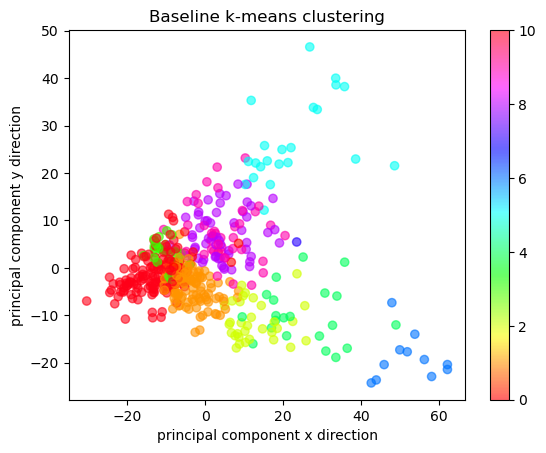

In [49]:
X = np.array(final_df['perc_change'].tolist())
pca = PCA(n_components=250) 
X_pca = pca.fit_transform(X)

kmeans = KMeans(n_clusters=11, random_state=24) # use of 11 explained in writing above
cluster_labels = kmeans.fit_predict(X_pca)

silh_score = silhouette_score(X_pca, cluster_labels)
print('silhouette score:', silh_score)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='hsv', alpha=0.6)
plt.title('Baseline k-means clustering')
plt.xlabel('principal component x direction')
plt.ylabel('principal component y direction')
plt.colorbar()
plt.show()

### PCA Analysis

In our stock market analysis, we used Principal Component Analysis (PCA) to reduce the complexity of our high-dimensional dataset, where each company’s stock data had 1250 observations. To determine the optimal number of components, we used the elbow method and found that 84 components explained about 95% of the variance, balancing dimensionality reduction and data integrity. We also addressed a data cleaning issue by excluding companies with fewer than 1250 observations, ensuring consistency for PCA.

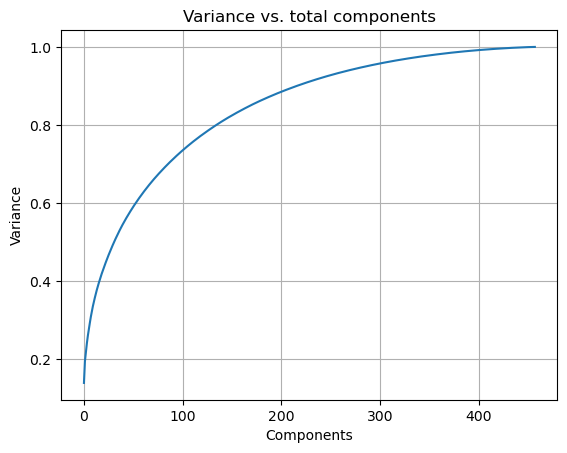

In [51]:
X = np.array(final_df['perc_change'].tolist())
pca = PCA()
pca.fit(X)

# elbow method shown here
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Components')
plt.ylabel('Variance')
plt.title('Variance vs. total components')
plt.grid(True)
plt.show()


In the following subsection we will conduct clustering of our data, cross validation for hyper parameter tuning, analysis of different final clusters and supervised learning analysis.

### Baseline K Means and GMM Models

To compare the performance of the GMM and K-means models on our dataset, we first implemented both models using 11 clusters, corresponding to the 11 industries in the S&P 500, to explore potential industry patterns. We began by establishing a baseline, running both models on PCA-processed data without any hyperparameter tuning. To evaluate the models, we visualized the results through graphs and calculated the silhouette scores for each model. This allowed us to assess how well the models performed in clustering the data and provided insight into their overall effectiveness.

/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


silhouette score: 0.04102334448551196


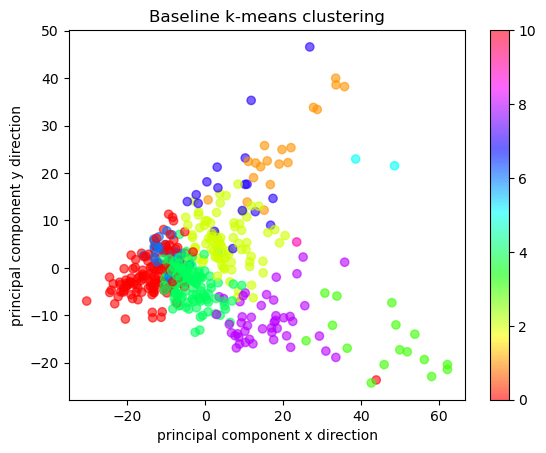

In [55]:
X = np.array(final_df['perc_change'].tolist())
pca = PCA(n_components=84) 
X_pca = pca.fit_transform(X)

kmeans = KMeans(n_clusters=11, random_state=24) # use of 11 explained in writing above
cluster_labels = kmeans.fit_predict(X_pca)

silh_score = silhouette_score(X_pca, cluster_labels)
print('silhouette score:', silh_score)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='hsv', alpha=0.6)
plt.title('Baseline k-means clustering')
plt.xlabel('principal component x direction')
plt.ylabel('principal component y direction')
plt.colorbar()
plt.show()

silhouette score: 0.03648402573979359


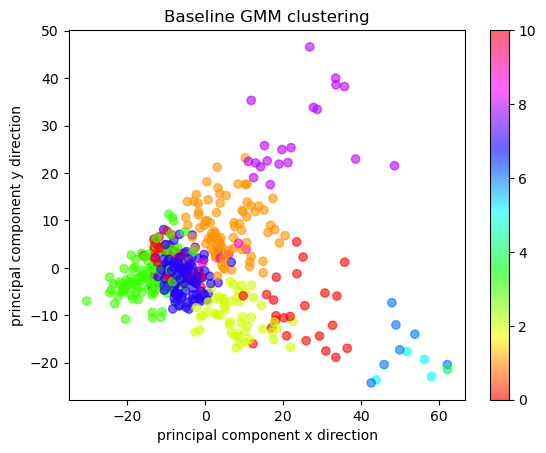

In [57]:
gmm = GaussianMixture(n_components=11, random_state=24)  
cluster_labels = gmm.fit_predict(X_pca)

silh_score = silhouette_score(X_pca, cluster_labels)
print('silhouette score:', silh_score)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='hsv', alpha=0.6)
plt.title('Baseline GMM clustering')
plt.xlabel('principal component x direction')
plt.ylabel('principal component y direction')
plt.colorbar()
plt.show()

### Comparison of Cluster Assignment between the two techiniques 

Due to the similarity in the silhouette scores of the two techiques, we printed out the clusters which were created just to ensure the validity of our data.

In [59]:
kmeans_labels = kmeans.predict(X_pca)
gmm_labels = gmm.predict(X_pca)

# Compare the cluster assignments
print("KMeans cluster assignments:", kmeans_labels[:10])
print("GMM cluster assignments:", gmm_labels[:10])

kmeans_silhouette = silhouette_score(X_pca, kmeans_labels)
gmm_silhouette = silhouette_score(X_pca, gmm_labels)

print(f"KMeans Silhouette Score: {kmeans_silhouette}")
print(f"GMM Silhouette Score: {gmm_silhouette}")

KMeans cluster assignments: [4 4 0 2 4 2 4 8 8 0]
GMM cluster assignments: [7 2 3 1 7 7 7 2 2 7]
KMeans Silhouette Score: 0.04102334448551196
GMM Silhouette Score: 0.03648402573979359


### Cross validation and optimization of Baseline GMM and K Means
To optimize our GMM and K-means models for clustering stocks, we used cross-validation to determine the ideal number of clusters. This process tested the models on different data segments, providing performance scores and ensuring robustness. Cross-validation helped us identify the optimal number of clusters that maximized coherence and distinction, which we assessed using the silhouette score. 

/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/

best # of clusters: 2
Corresponding best cross validation silhouette score 0.2806347380678378


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


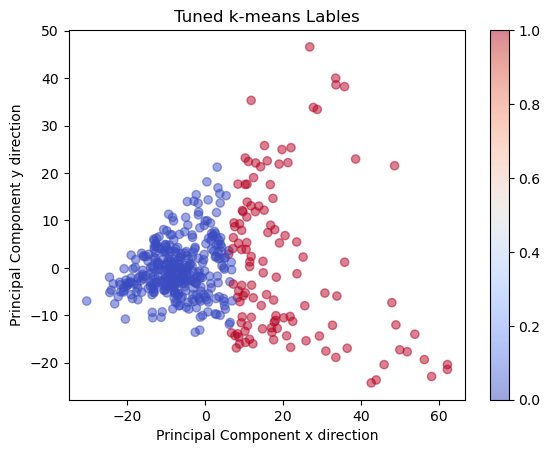

Silhouette score for graphed clustered: 0.27980117305393454


In [61]:
silhouette_scores = []

# corss validation here, note it is unseeded
for n_clusters in range(2, 19):
    kmeans = KMeans(n_clusters=n_clusters)
    cluster_labels = kmeans.fit_predict(X_pca)
    silh_score = silhouette_score(X_pca, cluster_labels)
    silhouette_scores += [silh_score]

final_cluster_num = np.argmax(silhouette_scores) + 2 # add 2 because corresponding index is left shifted

print("best # of clusters:", final_cluster_num)
print("Corresponding best cross validation silhouette score", silhouette_scores[final_cluster_num - 2])

#kmeans used new found best k param
kmeans = KMeans(n_clusters=final_cluster_num, random_state=24)
cluster_labels = kmeans.fit_predict(X_pca)

#saving labl results for later analysis in finl-df
final_df['k-means label'] = cluster_labels

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='coolwarm', alpha=0.5)
plt.title('Tuned k-means Lables')
plt.xlabel('Principal Component x direction')
plt.ylabel('Principal Component y direction')
plt.colorbar()
plt.show()

# silhoutte score from graphed kmeans clustering
final_silhouette_score = silhouette_score(X_pca, cluster_labels)
print("Silhouette score for graphed clustered:", final_silhouette_score)

best # of clusters: 2
Corresponding best cross validation silhouette score 0.3101538252601557


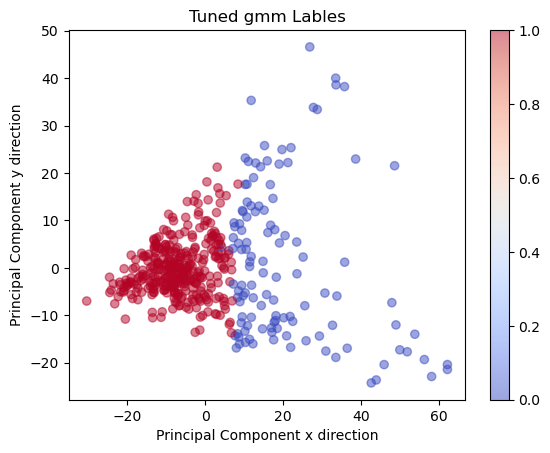

Silhouette score for graphed clustered: 0.2829969517374399


In [24]:
silhouette_scores = []

# cross validation here, note this part is unseeded
for n_components in range(2, 19):
    gmm = GaussianMixture(n_components=n_components)
    cluster_labels = gmm.fit_predict(X_pca)
    silh_score = silhouette_score(X_pca, cluster_labels)
    silhouette_scores.append(silh_score)

final_cluster_num = np.argmax(silhouette_scores) + 2

print("best # of clusters:", final_cluster_num)
print("Corresponding best cross validation silhouette score", silhouette_scores[final_cluster_num - 2])

gmm = GaussianMixture(n_components=final_cluster_num, random_state=24)
cluster_labels = gmm.fit_predict(X_pca)

# Update final_df with cluster labels
final_df['gmm labels'] = cluster_labels

# Plot the clustering labels

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='coolwarm', alpha=0.5)
plt.title('Tuned gmm Lables')
plt.xlabel('Principal Component x direction')
plt.ylabel('Principal Component y direction')
plt.colorbar()
plt.show()

final_silhouette_score = silhouette_score(X_pca, cluster_labels)
print("Silhouette score for graphed clustered:", final_silhouette_score)

### Comparing Clusters from Each Model

After improving the models, both GMM and K-means models repeeatedly selected 2 clusters in the cross validation. Since groups are now assigned to companies from the models, we will proceed with a performance analysis to learn how these clusters and models differ from each other. 

In [63]:
# peak at data frame after adding labels from our models
final_df.head(8)

,Company,perc_change,k-means label
0,A,"[0.4773218052326546, 1.0051671761984158, 1.827...",0
1,AAPL,"[1.702617183838854, 0.9484672021502785, 0.1951...",0
2,ABBV,"[1.011124035815082, 4.442714837058878, 0.69974...",0
3,ABEV,"[0.7025810290951009, 0.2347359508779906, 0.689...",0
5,ABT,"[1.1459365284516383, 0.1623194184859994, 0.026...",0
6,ACGL,"[0.38910046417311844, 0.5975397952022214, 1.11...",0
7,ACN,"[0.702792270799572, 1.6999443205598022, 0.5121...",0
8,ADBE,"[1.1081327004284363, 0.2637588112448539, 2.090...",1


In [69]:
# volatility comparision of Clusters in K-means Model
final_df['avg_volatility'] = final_df['perc_change'].apply(lambda x: x.mean())
final_df[['k-means label', 'avg_volatility']].groupby('k-means label').mean()

AttributeError: 'list' object has no attribute 'mean'

In [71]:
# volatility comparision of Clusters in GMM Model
final_df[['gmm labels', 'avg_volatility']].groupby('gmm labels').mean()

KeyError: "None of [Index(['gmm labels', 'avg_volatility'], dtype='object')] are in the [columns]"

In [ ]:
kmeans_0 = final_df.index[final_df['k-means label'] == 0].values

kmeans_1 = final_df.index[final_df['k-means label'] == 1].values

gmm_0 = final_df.index[final_df['gmm labels'] == 0].values

gmm_1 = final_df.index[final_df['gmm labels'] == 1].values

#lengths of each 

print("k-means 0 length:", len(kmeans_0))
print("k-means 1 length:", len(kmeans_1), '\n')
print("gmm 0 length:", len(gmm_0))
print("gmm 1 length:", len(gmm_1), '\n')

# to visualize what these arrays look like here is a snippet of first 10 companies in the 1-label groups
print(gmm_1[0:10])
print(kmeans_1[0:10])

In [ ]:
kmeans_0 = final_df.index[final_df['k-means label'] == 0].values

kmeans_1 = final_df.index[final_df['k-means label'] == 1].values

gmm_0 = final_df.index[final_df['gmm labels'] == 0].values

gmm_1 = final_df.index[final_df['gmm labels'] == 1].values

#lengths of each 

print("k-means 0 length:", len(kmeans_0))
print("k-means 1 length:", len(kmeans_1), '\n')
print("gmm 0 length:", len(gmm_0))
print("gmm 1 length:", len(gmm_1), '\n')

# to visualize what these arrays look like here is a snippet of first 10 companies in the 1-label groups
print(gmm_1[0:10])
print(kmeans_1[0:10])

In [ ]:
# Finding Average Cost Price for each company over last 3 month period in dataset
last_quart_cutoff = df1['Date'].max() - timedelta(days=90)  #90 for 3 months (1 financial quarter)

final_quarter_only = df1[df1['Date'] >= last_quart_cutoff]

final_quarter_avgs = final_quarter_only.groupby('Company').mean()

final_quarter_avgs  = final_quarter_avgs.drop(columns=['Open', 'High', 'Low', 'Volume', "Dividends", 'Stock Splits'])
final_quarter_avgs

#### Utilize Boxplots to show performance of clusters

Given the large size of each cluster resulting from using only two clusters per model, our group determined that relying on the mean as a metric would be unfair and inaccurate for comparing average closing prices and growth across clusters. To address this issue, we implemented boxplots for each cluster, allowing us to analyze the median and various quartiles for a more precise representation of cluster differences. This approach is particularly advantageous because the mean is highly sensitive to outliers, and the substantial number of points in each cluster increases the likelihood of metrics being skewed by these outliers. By focusing on the median and quartiles, which are more robust against outliers, we achieved a less biased and more reliable comparison between clusters.

In [ ]:
# K-means section
kmean_0_avgs = final_quarter_avgs[final_quarter_avgs.index.isin(kmeans_0)]
kmean_1_avgs = final_quarter_avgs[final_quarter_avgs.index.isin(kmeans_1)]

fig, ax = plt.subplots()

box1 = kmean_0_avgs.boxplot(column='Close',  positions=[1])
box2 = kmean_1_avgs.boxplot(column='Close',  positions=[2])

ax.set_xticks([1, 2])
ax.set_xticklabels(['label 0 group', 'label 1 group'])

ax.set_ylabel('Latest avg close price')
ax.set_title('k-means labels distribution of close prices')

plt.show()

# after creating code for plot we use code below to print the actual values this is due to ranges being so different

kmeans0_median = kmean_0_avgs['Close'].median()
kmeans0_lower_q = kmean_0_avgs['Close'].quantile(0.25)
kmeans0_upper_q = kmean_0_avgs['Close'].quantile(0.75)

kmeans1_median = kmean_1_avgs['Close'].median()
kmeans1_lower_q = kmean_1_avgs['Close'].quantile(0.25)
kmeans1_upper_q = kmean_1_avgs['Close'].quantile(0.75)

print("Median label 0 Median:", kmeans0_median)
print("Lower quartile label 0:", kmeans0_lower_q)
print("Upper quartile label 0:", kmeans0_upper_q, '\n')

print("Median for label 1 group:", kmeans1_median)
print("Lower quartile label 1:", kmeans1_lower_q)
print("Upper quartile label 1:", kmeans1_upper_q)

plt.show()


In [ ]:
# GMM section
gmm_0_avgs = final_quarter_avgs[final_quarter_avgs.index.isin(gmm_0)]
gmm_1_avgs = final_quarter_avgs[final_quarter_avgs.index.isin(gmm_1)]

fig, ax = plt.subplots()

box1 = gmm_0_avgs.boxplot(column='Close',  positions=[1])
box2 = gmm_1_avgs.boxplot(column='Close',  positions=[2])

ax.set_xticks([1, 2])
ax.set_xticklabels(['label 0 group', 'label 1 group'])

ax.set_ylabel('Latest avg close price')
ax.set_title('GMM labels distribution of close prices')

plt.show()

gmm_0_avgs = final_quarter_avgs[final_quarter_avgs.index.isin(gmm_0)]
gmm_1_avgs = final_quarter_avgs[final_quarter_avgs.index.isin(gmm_1)]

gmm0_median = gmm_0_avgs['Close'].median()
gmm0_lower_q = gmm_0_avgs['Close'].quantile(0.25)
gmm0_upper_q = gmm_0_avgs['Close'].quantile(0.75)

gmm1_median = gmm_1_avgs['Close'].median()
gmm1_lower_q = gmm_1_avgs['Close'].quantile(0.25)
gmm1_upper_q = gmm_1_avgs['Close'].quantile(0.75)

print("Median label 0 Median:", gmm0_median)
print("Lower quartile label 0:", gmm0_lower_q)
print("Upper quartile label 0:", gmm0_upper_q, '\n')

print("Median for label 1 group:", gmm1_median)
print("Lower quartile label 1:", gmm1_lower_q)
print("Upper quartile label 1:", gmm1_upper_q)


#### Analysis of Growth
In this section, we shift our focus to comparing the average growth percentages of the clusters rather than their average closing prices. Similar to the earlier approach, we rely on medians and quartiles to evaluate cluster performance. This method minimizes the influence of outliers, ensuring a more reliable and accurate comparison between clusters.

In [ ]:
#calculating grow for companies
def get_last3_month(array):
    
    return sum(array[-90:]) / 90.0

final_df['avg last 90']= final_df['perc_change'].apply(get_last3_month)

final_90_changes = final_df['avg last 90'].to_frame()
final_90_changes

kmean_0_changes = final_90_changes[final_90_changes.index.isin(kmeans_0)]
kmean_1_changes = final_90_changes[final_90_changes.index.isin(kmeans_1)]

#preview of data used:

kmean_0_changes[:5]

In [ ]:
# K-means growth calculation
def get_last3_month(array):
    
    return sum(array[-90:]) / 90.0

final_df['avg last 90']= final_df['perc_change'].apply(get_last3_month)

final_90_changes = final_df['avg last 90'].to_frame()
final_90_changes

kmean_0_changes = final_90_changes[final_90_changes.index.isin(kmeans_0)]
kmean_1_changes = final_90_changes[final_90_changes.index.isin(kmeans_1)]


fig, ax = plt.subplots()

final_box1 = kmean_0_changes.boxplot(column='avg last 90',  positions=[1])
final_box2 = kmean_1_changes.boxplot(column='avg last 90',  positions=[2])


ax.set_xticks([1, 2])
ax.set_xticklabels(['label 0 group', 'label 1 group'])

ax.set_ylabel('k-means Average volalites of each cluster')
ax.set_title('k-means labels distribution of close prices')

plt.show()

In [ ]:
# GMM growth calculation
gmm_0_changes = final_90_changes[final_90_changes.index.isin(gmm_0)]
gmm_1_changes = final_90_changes[final_90_changes.index.isin(gmm_1)]


fig, ax = plt.subplots()

final_box1 = gmm_0_changes.boxplot(column='avg last 90',  positions=[1])
final_box2 = gmm_1_changes.boxplot(column='avg last 90',  positions=[2])


ax.set_xticks([1, 2])
ax.set_xticklabels(['label 0 group', 'label 1 group'])

ax.set_ylabel('gmm Average volalites of each cluster')
ax.set_title('gmm labels distribution of close prices')

plt.show()